# Benchmark models

Two models were chosen from the MTEB Leaderboard to serve as state-of-the-art benchmarks for evaluating the quality of the newly developed model. It was important to select models that were relatively small to ensure compatibility with the available resources. For instance, the top-ranked model (bge-en-icl) and the second-ranked model (stella_en_1.5B_v5) were considered, but their implementation was not feasible due to resource limitations.

In [4]:
#Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.patheffects as PathEffects
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

In [5]:
#Load data
posts = pd.read_csv("data/preprocessed/total_posts.csv")
posts = posts.sample(n=20000, random_state=1234)

In [6]:
# Create list of sentences and list of words
lemmatized_posts = posts["title_and_text_lemmatized"].tolist()
post_corpus = [doc.split() for doc in lemmatized_posts]

# Get unnested list of words
word_list = []
for sublist in post_corpus:
    word_list.extend(sublist)

# Create a vocabulary: count occurrences of each word
vocab = defaultdict(int)
for sentence in post_corpus:
    for word in sentence:
        vocab[word] += 1

min_count = 40

# Remove infrequent words from the vocabulary
vocab = {word: count for word, count in vocab.items() if count >= min_count}

# Create word to index and index to word mappings
word_to_index = {word: idx for idx, (word, _) in enumerate(vocab.items())}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Create DataFrame from vocabulary
vocab_df = pd.DataFrame(list(vocab.items()), columns=['Word', 'Count'])

vocab_set = set(vocab.keys())

The first model we selected was a GloVe model, which is an extension of Word2Vec, and its size made it suitable for implementation.

https://huggingface.co/sentence-transformers/average_word_embeddings_glove.6B.300d

In [7]:
# Load the GloVe model
glove_model = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d')

# Process your lemmatized posts
processed_words_glove = [glove_model.encode(word) for word in word_list]

# Create a DataFrame from the embeddings
df_glove_embeddings = pd.DataFrame(processed_words_glove)

# Add the 'lemmatized_post' column for context
df_glove_embeddings['word'] = word_list

# Save the resulting DataFrame
df_glove_embeddings.to_csv("embeddings/glove_embeddings.csv")

c:\Users\wirth\anaconda3\Lib\site-packages\sentence_transformers\models\WordEmbeddings.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(os.path.joi

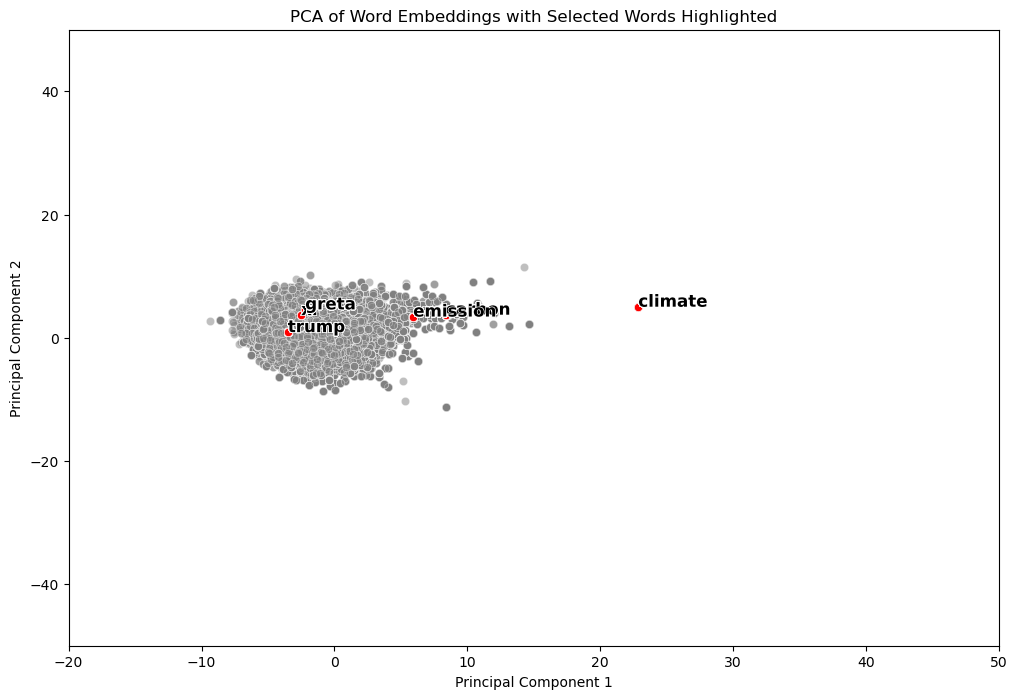

In [8]:
# Drop the non-numerical 'word' column
X = df_glove_embeddings.drop(columns=['word'])

X_standardized = StandardScaler().fit_transform(X)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the 'word' column back for labeling
pca_df['word'] = df_glove_embeddings['word']

# Specify the words you want to highlight
highlight_words = ["climate",  "trump", "greta", "xi", "emission", "carbon"]

# Filter the DataFrame to include only the selected words
highlight_df = pca_df[pca_df['word'].isin(highlight_words)]

# Plotting the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, color='gray', alpha=0.5)

# Highlight the selected words in a different color
sns.scatterplot(x='PC1', y='PC2', data=highlight_df, color='red')

# Annotate the points with the selected word labels with improved styling
for i in range(highlight_df.shape[0]):
    txt = plt.text(x=highlight_df.PC1.iloc[i], y=highlight_df.PC2.iloc[i], s=highlight_df.word.iloc[i], 
                   fontdict=dict(color='black', size=12, weight='bold'))
    
    # Add a white outline to the text for better visibility
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='white')])
plt.xlim(-20, 50)  # Example limits for PC1
plt.ylim(-50, 50)  # Example limits for PC2
plt.title('PCA of Word Embeddings with Selected Words Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

As the second model, we used the small version of the bge model. Its larger counterpart currently holds the top position on the leaderboard.

https://huggingface.co/BAAI/bge-small-en-v1.5

In [9]:
# Load the BAAI/bge-small-en-v1.5 model
bge_model = SentenceTransformer('BAAI/bge-small-en-v1.5')

# Process your lemmatized posts using the BGE model
processed_words_bge = [bge_model.encode(word) for word in word_list]

# Create a DataFrame from the embeddings
df_bge_embeddings = pd.DataFrame(processed_words_bge)

# Add the 'word' column for context
df_bge_embeddings['word'] = word_list

# Save the resulting DataFrame
df_bge_embeddings.to_csv("embeddings/bge_embeddings.csv")

c:\Users\wirth\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


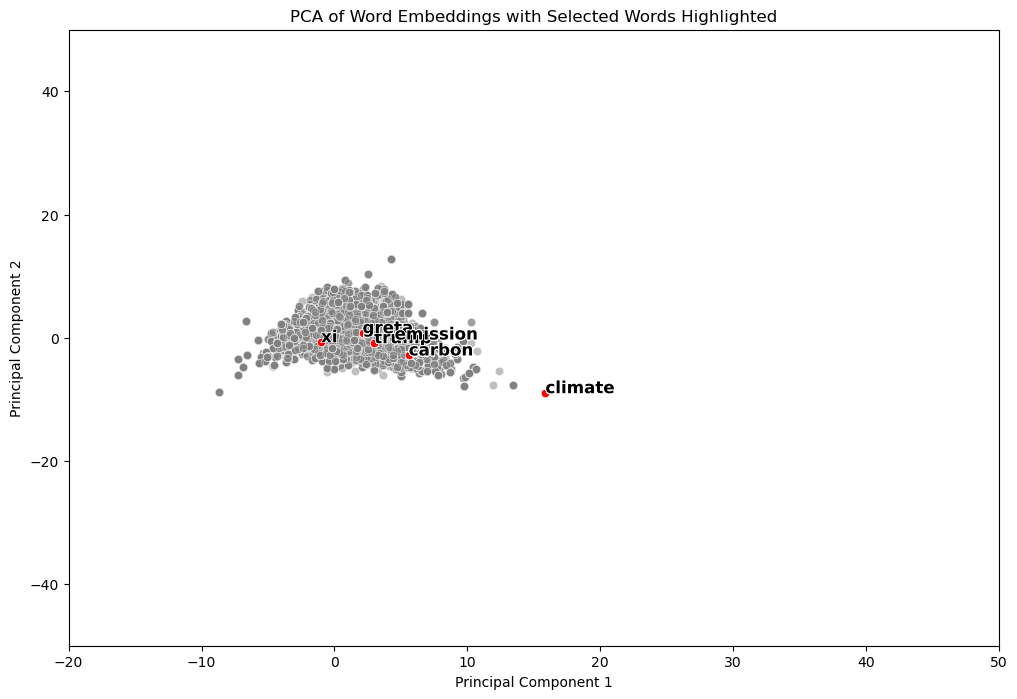

In [ ]:
# Drop the non-numerical 'word' column
X = df_bge_embeddings.drop(columns=['word'])

X_standardized = StandardScaler().fit_transform(X)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the 'word' column back for labeling
pca_df['word'] = df_bge_embeddings['word']

# Specify the words you want to highlight
highlight_words = ["climate",  "trump", "greta", "xi", "emission", "carbon"]

# Filter the DataFrame to include only the selected words
highlight_df = pca_df[pca_df['word'].isin(highlight_words)]

# Plotting the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, color='gray', alpha=0.5)

# Highlight the selected words in a different color
sns.scatterplot(x='PC1', y='PC2', data=highlight_df, color='red')

# Annotate the points with the selected word labels with improved styling
for i in range(highlight_df.shape[0]):
    txt = plt.text(x=highlight_df.PC1.iloc[i], y=highlight_df.PC2.iloc[i], s=highlight_df.word.iloc[i], 
                   fontdict=dict(color='black', size=12, weight='bold'))
    
    # Add a white outline to the text for better visibility
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='white')])
plt.xlim(-20, 50)  # Example limits for PC1
plt.ylim(-50, 50)  # Example limits for PC2
plt.title('PCA of Word Embeddings with Selected Words Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()